In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import minRLHF
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    AutoModelForTokenClassification
)

/home/ubuntu/minRLHF/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from minRLHF.environment import Environment
import random
from transformers.pipelines import pipeline

reward_model = pipeline(
    "text-classification",
    model='bhadresh-savani/distilbert-base-uncased-emotion', 
    return_all_scores=True
)

class MyEnv(Environment):
    def get_input_prompt(self) -> str:
        return random.choice([
            'I went for a walk one day and',
            'A long time ago, in a galaxy far far away',
            'Oops! I'
        ])
        
    def score_generation(self, text: str) -> float:
        sentiment_scores = reward_model(text)[0]
        sentiment_scores = {d['label']: d['score'] for d in sentiment_scores}
        return sentiment_scores['joy']

/home/ubuntu/minRLHF/.venv/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [4]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

model = AutoModelForCausalLM.from_pretrained('gpt2').to('cuda')
reference = AutoModelForCausalLM.from_pretrained('gpt2').to('cuda')
critic = AutoModelForTokenClassification.from_pretrained('gpt2', num_labels=1).to('cuda')

# Instantiate envrionment
env = MyEnv(tokenizer, batch_size=16)

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'classifier.bias', 'h.4.attn.masked_bias', 'h.9.attn.masked_bias', 'h.8.attn.masked_bias', 'classifier.weight', 'h.2.attn.masked_bias', 'h.11.attn.masked_bias', 'h.3.attn.masked_bias', 'h.10.attn.masked_bias', 'h.7.attn.masked_bias', 'h.5.attn.masked_bias', 'h.1.attn.masked_bias', 'h.6.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from minRLHF.ppo_trainer import PPOTrainer

# Create PPO trainer
ppo_trainer = PPOTrainer(
    actor_model=model,
    critic_model=critic,
    reference_model=reference,
    env=env,
)

In [10]:
ppo_trainer.train()

Completed epoch 0.
reward_mean: 0.506142258644104 (0.506142258644104 average)
reward_std: 0.4182848632335663 (0.4182848632335663 average)
augmented_reward: -0.011102182790637016 (-0.011102182790637016 average)
completion_length_mean: 89.0 (89.0 average)
completion_length_std: 0.0 (0.0 average)
kld_t-1: -0.626872181892395 (-0.626872181892395 average)
kld_0: -1.366380214691162 (-1.366380214691162 average)
entropy: 1.9532020092010498 (1.9532020092010498 average)
mae: 1.321537733078003 (1.321537733078003 average)

Completed epoch 1.
reward_mean: 0.5330030918121338 (0.5064108669757843 average)
reward_std: 0.4213164448738098 (0.41831517904996873 average)
augmented_reward: -0.886354386806488 (-0.019854704830795537 average)
completion_length_mean: 89.0 (89.0 average)
completion_length_std: 0.0 (0.0 average)
kld_t-1: -0.07289758324623108 (-0.6213324359059335 average)
kld_0: -2.145955801010132 (-1.374175970554352 average)
entropy: 1.6252460479736328 (1.9499224495887755 average)
mae: 1.1221396923

RuntimeError: CUDA out of memory. Tried to allocate 308.00 MiB (GPU 0; 14.76 GiB total capacity; 13.01 GiB already allocated; 283.75 MiB free; 13.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

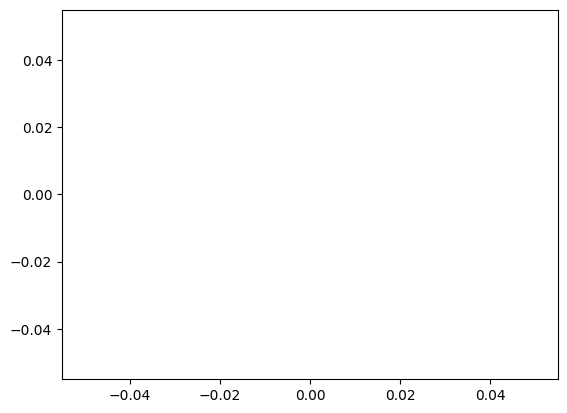

In [8]:
import matplotlib.pyplot as plt

xs = list(range(len(ppo_trainer.rolling_rewards)))
ys = ppo_trainer.rolling_rewards

window_size = 10
smoothed_ys = [sum(ys[max(0, idx-window_size):idx])/window_size for idx, _ in enumerate(ys)]

plt.scatter(xs, ys, s=1)
plt.plot(smoothed_ys)

In [47]:
inputs = tokenizer('I went for a walk one day and', return_tensors='pt')
outputs = reference.generate(inputs.input_ids.to(model.device), max_length=100, do_sample=True)
text = tokenizer.batch_decode(outputs)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
